In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display, Markdown
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from time import perf_counter
import seaborn as sns

def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))

In [2]:
image_dir = Path('C:/Users/sm160/OneDrive - Amity University/Desktop/amity/sem8/dataset/gaussian_filtered_images/gaussian_filtered_images')

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

In [3]:
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

# Show the result
image_df.head(5)

,Filepath,Label
0,C:\Users\sm160\OneDrive - Amity University\Des...,No_DR
1,C:\Users\sm160\OneDrive - Amity University\Des...,Moderate
2,C:\Users\sm160\OneDrive - Amity University\Des...,No_DR
3,C:\Users\sm160\OneDrive - Amity University\Des...,No_DR
4,C:\Users\sm160\OneDrive - Amity University\Des...,Moderate


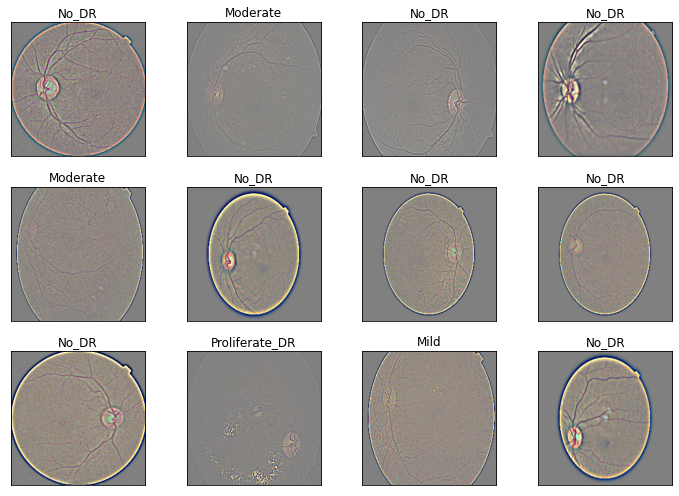

In [4]:
# Display some pictures of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

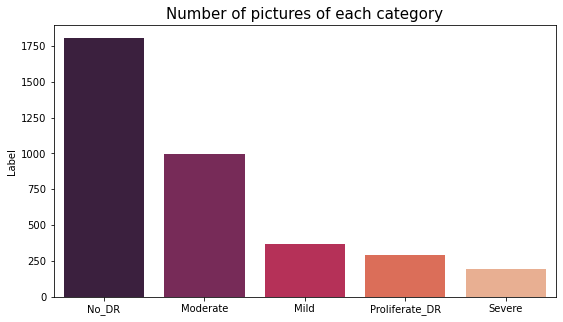

No_DR             1805
Moderate           999
Mild               370
Proliferate_DR     295
Severe             193
Name: Label, dtype: int64


In [5]:
# Display the number of pictures of each category
vc = image_df['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()
print(vc)

In [6]:
def create_gen():
    # Load the Images with a generator and Data Augmentation
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )
    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30, # Uncomment to use data augmentation
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )
    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30, # Uncomment to use data augmentation
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )
    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    
    return train_generator,test_generator,train_images,val_images,test_images


In [7]:
def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}
    
    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False
    
    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [8]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, train_size=0.9, shuffle=True, random_state=1)

In [9]:
train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

Found 2966 validated image filenames belonging to 5 classes.
Found 329 validated image filenames belonging to 5 classes.
Found 367 validated image filenames belonging to 5 classes.




In [14]:
print(test_df)

                                               Filepath     Label
2830  C:\Users\sm160\OneDrive - Amity University\Des...     No_DR
1247  C:\Users\sm160\OneDrive - Amity University\Des...     No_DR
102   C:\Users\sm160\OneDrive - Amity University\Des...     No_DR
2687  C:\Users\sm160\OneDrive - Amity University\Des...     No_DR
2868  C:\Users\sm160\OneDrive - Amity University\Des...    Severe
...                                                 ...       ...
3339  C:\Users\sm160\OneDrive - Amity University\Des...  Moderate
2984  C:\Users\sm160\OneDrive - Amity University\Des...    Severe
3438  C:\Users\sm160\OneDrive - Amity University\Des...  Moderate
3651  C:\Users\sm160\OneDrive - Amity University\Des...     No_DR
301   C:\Users\sm160\OneDrive - Amity University\Des...      Mild

[367 rows x 2 columns]


In [10]:
 #Dictionary with the models
models = {
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0}
}
# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

# Fit the models
for name, model in models.items():
    # Get the model
    m = get_model(model['model'])
    models[name]['model'] = m
    
    start = perf_counter()
    
    # Fit the model
    history = m.fit(train_images,validation_data=val_images,epochs=1,verbose=1)
    # Save the duration, the train_accuracy and the val_accuracy
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")
    
    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]
    
    train_acc = history.history['accuracy']
    models[name]['train_accuracy'] = [round(v,4) for v in train_acc]

Found 2966 validated image filenames belonging to 5 classes.
Found 329 validated image filenames belonging to 5 classes.
Found 367 validated image filenames belonging to 5 classes.


93/93 [==============================] - 69s 700ms/step - loss: 0.8128 - accuracy: 0.7175 - val_loss: 0.6712 - val_accuracy: 0.7599
MobileNetV2          trained in 69.17 sec


In [11]:
print(history.history)
print(history)

{'loss': [0.978674054145813], 'accuracy': [0.6540795564651489], 'val_loss': [0.8606994152069092], 'val_accuracy': [0.7051671743392944]}


In [14]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [15]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [16]:
def lr_rate(epoch,lr):
    if epoch<10:
        lr=0.0001
        return lr
    elif epoch<=15:
        lr=0.0005
        return lr
    elif epoch<=30:
        lr=0.0001
        return lr
    else:
        lr=lr*(epoch/(1+epoch))
        return lr
lr_callback=tf.keras.callbacks.LearningRateScheduler(lr_rate)

In [17]:

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=50,
    callbacks=[lr_callback],
    verbose=1
)

Epoch 1/50
93/93 [==============================] - 49s 487ms/step - loss: 1.0072 - accuracy: 0.6365 - val_loss: 0.7712 - val_accuracy: 0.7356 - lr: 1.0000e-04
Epoch 2/50
93/93 [==============================] - 41s 441ms/step - loss: 0.7429 - accuracy: 0.7296 - val_loss: 0.6828 - val_accuracy: 0.7386 - lr: 1.0000e-04
Epoch 3/50
93/93 [==============================] - 41s 442ms/step - loss: 0.6733 - accuracy: 0.7572 - val_loss: 0.6465 - val_accuracy: 0.7386 - lr: 1.0000e-04
Epoch 4/50
93/93 [==============================] - 40s 431ms/step - loss: 0.6301 - accuracy: 0.7684 - val_loss: 0.6259 - val_accuracy: 0.7629 - lr: 1.0000e-04
Epoch 5/50
93/93 [==============================] - 40s 435ms/step - loss: 0.5976 - accuracy: 0.7798 - val_loss: 0.6226 - val_accuracy: 0.7538 - lr: 1.0000e-04
Epoch 6/50
93/93 [==============================] - 46s 496ms/step - loss: 0.5751 - accuracy: 0.7866 - val_loss: 0.5995 - val_accuracy: 0.7629 - lr: 1.0000e-04
Epoch 7/50
93/93 [======================

In [12]:
sheet1=pd.DataFrame(history.history)[['accuracy','val_accuracy']]
acc_sheet=sheet1*100
with pd.ExcelWriter('C:/Users/sm160/OneDrive - Amity University/Desktop/mobres.xlsx') as writer:  
    acc_sheet.to_excel(writer, sheet_name='Sheet1')

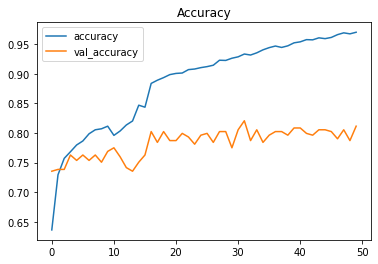

In [18]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

In [44]:
sheet2=pd.DataFrame(history.history)[['loss','val_loss']]
print(sheet2)
with pd.ExcelWriter('C:/Users/sm160/OneDrive - Amity University/Desktop/output2.xlsx') as writer:  
    sheet2.to_excel(writer, sheet_name='Sheet2')

        loss  val_loss
0   1.007180  0.771178
1   0.742922  0.682811
2   0.673257  0.646524
3   0.630114  0.625903
4   0.597622  0.622608
5   0.575105  0.599458
6   0.551325  0.596076
7   0.532246  0.590764
8   0.520497  0.594462
9   0.502665  0.571486
10  0.546582  0.577519
11  0.515679  0.666053
12  0.502847  0.634760
13  0.470989  0.630872
14  0.421968  0.622682
15  0.414696  0.603562
16  0.335246  0.537872
17  0.316288  0.550312
18  0.308411  0.546951
19  0.297163  0.561118
20  0.289546  0.557358
21  0.281022  0.550599
22  0.274973  0.571066
23  0.267013  0.563211
24  0.257724  0.553360
25  0.253436  0.569238
26  0.246791  0.566604
27  0.237913  0.580429
28  0.232583  0.575645
29  0.226333  0.612533
30  0.219031  0.572297
31  0.210894  0.583178
32  0.208046  0.586536
33  0.199352  0.579283
34  0.191568  0.592131
35  0.184856  0.579923
36  0.181660  0.593528
37  0.175708  0.589289
38  0.173360  0.597842
39  0.163157  0.609298
40  0.161354  0.604349
41  0.156479  0.621383
42  0.15195

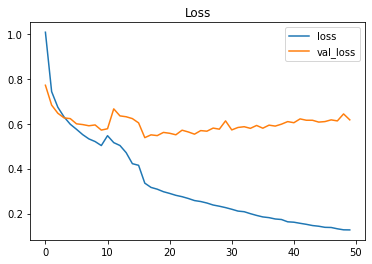

In [19]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [ ]:
for name, v in models.items():
    models_result.append([ name, 
                          models[name]['train_accuracy'][-1],
                          models[name]['val_acc'][-1], 
                          models[name]['perf']])
    
df_results = pd.DataFrame(models_result, 
                          columns = ['model','train_accuracy','val_accuracy','Training time (sec)'])


In [20]:
results = model.evaluate(test_images, verbose=0)

In [21]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

12/12 [==============================] - 6s 383ms/step
The first 5 predictions: ['No_DR', 'Moderate', 'Moderate', 'Moderate', 'No_DR']


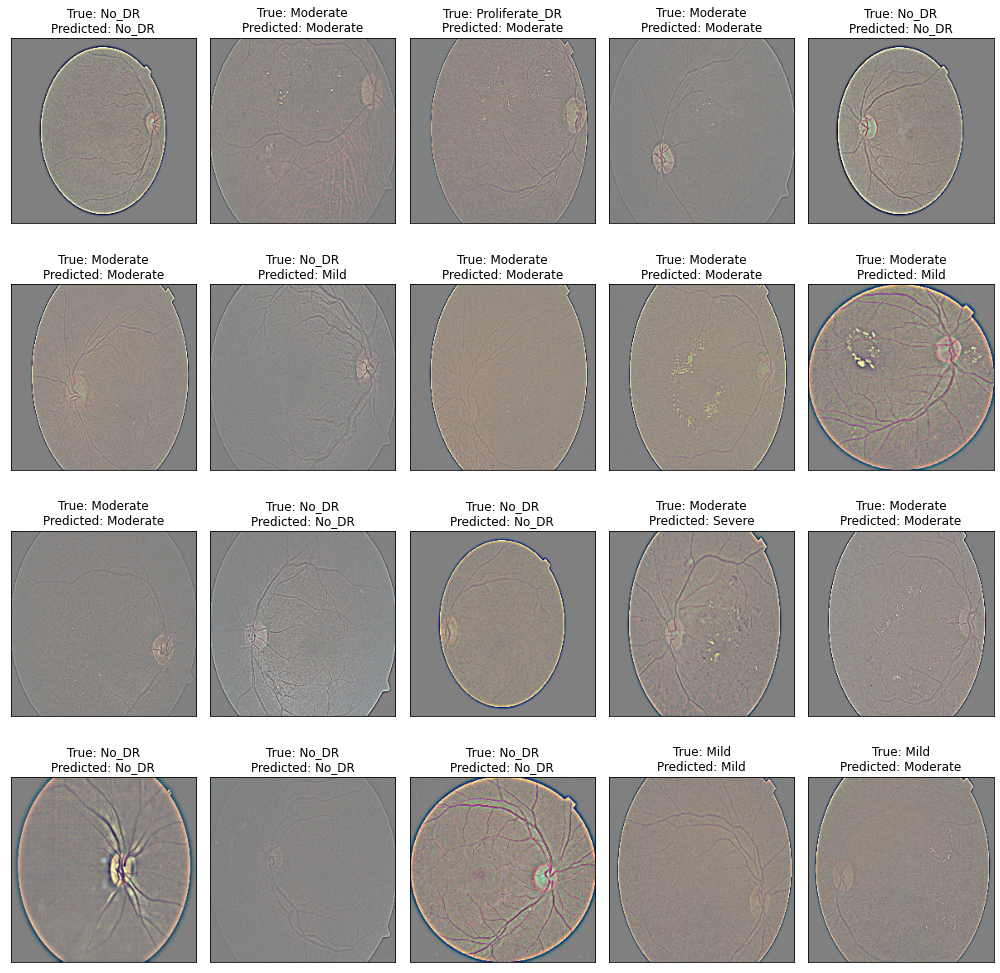

In [50]:
# Display some pictures of the dataset with their labels and the predictions
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(14, 14),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

In [13]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display, Markdown
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from time import perf_counter
import seaborn as sns

import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

%matplotlib inline

[[112, 0, 3, 5, 1], [0, 83, 0, 2, 7], [17, 0, 60, 3, 2], [3, 4, 3, 38, 3], [3, 2, 3, 0, 13]]


<Figure size 1080x720 with 0 Axes>

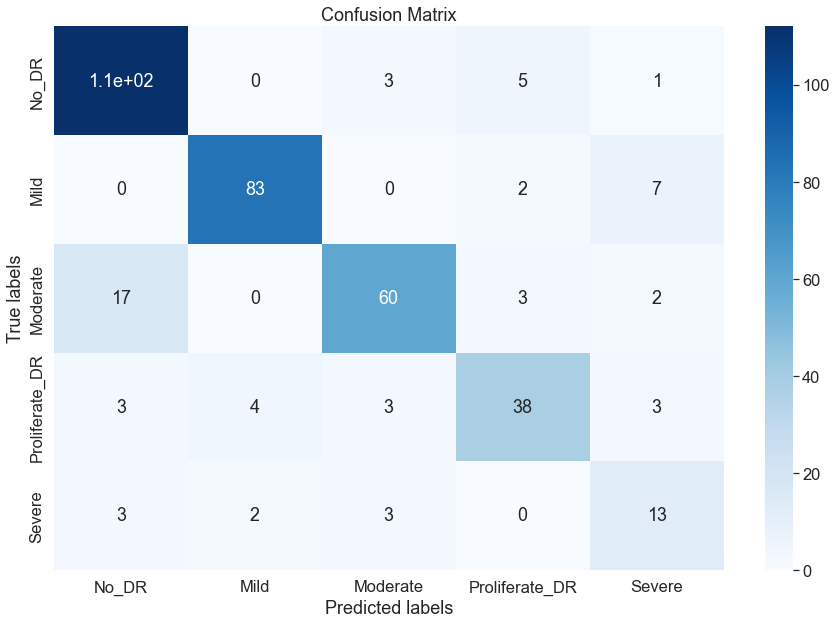

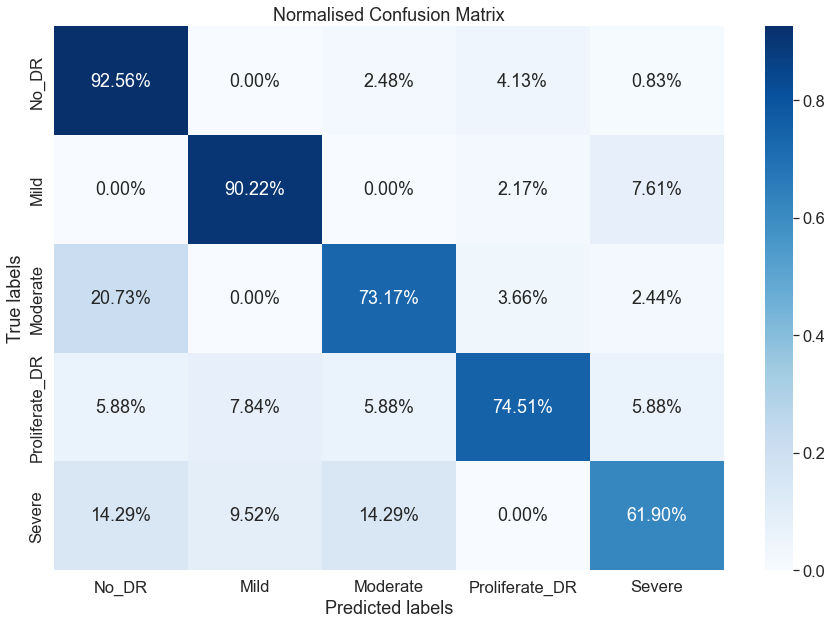

In [14]:
#MOBILENET
# sns.heatmap(cm, annot=True,cmap="Blues",ax=ax)
plt.figure(figsize=(15,10))
sns.set(font_scale=1.5)

cm=[[112,0,3,5,1],[0,83,0,2,7],[17,0,60,3,2],[3,4,3,38,3],[3,2,3,0,13]]
print(cm)
plt.figure(figsize=(15,10))
sns.set(font_scale=1.5)

ax= plt.subplot()
sns.heatmap(cm, annot=True,cmap="Blues",ax=ax)
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');

ax.xaxis.set_ticklabels(["No_DR", "Mild", "Moderate","Proliferate_DR","Severe"]); ax.yaxis.set_ticklabels(["No_DR", "Mild", "Moderate","Proliferate_DR","Severe"]);

#--------------------------
plt.figure(figsize=(15,10))
sns.set(font_scale=1.5)

ax= plt.subplot()

confusion_matrix=np.array([[112,0,3,5,1],[0,83,0,2,7],[17,0,60,3,2],[3,4,3,38,3],[3,2,3,0,13]])
cm_normalized = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, cmap="Blues",fmt='.2%')

ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Normalised Confusion Matrix');

ax.xaxis.set_ticklabels(["No_DR", "Mild", "Moderate","Proliferate_DR","Severe"]); ax.yaxis.set_ticklabels(["No_DR", "Mild", "Moderate","Proliferate_DR","Severe"]);
